# Unit Commitment

_**[Power Systems Optimization](https://github.com/east-winds/power-systems-optimization)**_

_by Michael R. Davidson and Jesse D. Jenkins (last updated: October 11, 2022)_

This notebook will build on the economic dispatch (ED) model by introducing binary startup (called "commitment") decisions, constraints, and costs of thermal generators. Similar to ED, it minimizes the short-run production costs of meeting electricity demand, but these additions are necessary for operating systems with large amounts of (inflexible) thermal generation. They also entail significant computational trade-offs.

****

We build up the model in several stages. We first start with the simplest model that incorporates unit commitment decisions in order to understand the logic of three-variable commitment formulations.

Next, we introduce moderate complexity through the addition of ramp constraints&mdash;which we need to be modified from the ED to account for startups and shutdowns.

Finally, we model a more realistic unit commitment that includes reserves&mdash;an important feature of day-ahead scheduling in power systems.

## Introduction to unit commitment

Engineering considerations severely limit the possible output ranges of power plants. System operators need to be aware of these limitations when scheduling generation to meet demand. Thermal power plants, in particular, due to their complex designs, thermodynamic cycles, and material properties, can be particularly challenging. In practice, due to the times involved in bringing these power plants online, much of this scheduling is done day-ahead, which gives rise to the need for a day-ahead market.

**Unit commitment** (UC) is the problem of minimizing short-run costs of production inclusive of production and startup costs, in order to meet a given demand and considering relevant engineering constraints of the generators. It is built on the ED model in that it typically considers all of the same variables in addition to the new startup-related variables and constraints&mdash;hence, it is also sometimes called unit commitment and economic dispatch (UCED). This notebook, for simplicity, only considers a single-bus case, while typical formulations usually include a simplified network representation.

## Simple unit commitment

We start with the simplest case that incorporates unit commitment, building on the `economic_dispatch_multi` problem of the [Economic Dispatch notebook](04-Economic-Dispatch.ipynb).


$$
\begin{align}
\min \ & \sum_{g \in G, t \in T} VarCost_g \times GEN_{g,t} + \sum_{g \in G_{thermal}, t \in T} StartUpCost_g \times START_{g,t} \\
\end{align}
$$
$$
\begin{align}
\text{s.t.} & \\
 & \sum_{g} GEN_{g,t} = Demand_t & \forall \quad t \in T \\
 & GEN_{g,t} \leq Pmax_{g,t} & \forall \quad g \notin G_{thermal} , t \in T \\
 & GEN_{g,t} \geq Pmin_{g,t} & \forall \quad g \notin G_{thermal} , t \in T \\
 & GEN_{g,t} \leq Pmax_{g,t} \times COMMIT_{g,t} & \forall \quad g \in G_{thermal} , t \in T \\
 & GEN_{g,t} \geq Pmin_{g,t} \times COMMIT_{g,t} & \forall \quad g \in G_{thermal} , t \in T \\
 & COMMIT_{g,t} \geq \sum_{t'≥t-MinUp_g}^{t} START_{g,t} & \forall \quad g \in G_{thermal} , t \in T \\
 & 1-COMMIT_{g,t} \geq \sum_{t'≥t-MinDown_g}^{t} SHUT_{g,t} &\forall \quad g \in G_{thermal} , t \in T \\
  & COMMIT_{g,t+1} - COMMIT_{g,t} =&\\
 & \quad START_{g,t+1} - SHUT_{g,t+1} &\forall \quad G_{thermal} \in G , t = 1..T-1 
\end{align}
$$


The **decision variables** in the above problem:

- $GEN_{g}$, generation (in MW) produced by each generator, $g$
- $START_{g,t}$, startup decision (binary) of thermal generator $g$ at time $t$
- $SHUT_{g,t}$, shutdown decision (binary) of thermal generator $g$ at time $t$
- $COMMIT_{g,t}$, commitment status (binary) of generator $g$ at time $t$

The **parameters** are:

- $Pmin_g$, the minimum operating bounds for generator $g$ (based on engineering or natural resource constraints)
- $Pmax_g$, the maximum operating bounds for generator $g$ (based on engineering or natural resource constraints)
- $Demand$, the demand (in MW)
- $VarCost_g = VarOM_g + HeatRate_g \times FuelCost_g$, the variable cost of generator $g$ 
- $StartUpCost_g$, the startup cost of generator $g$
- $MinUp_g$, the minimum up time of generator $g$, or the minimum time after start-up before a unit can shut down
- $MinDown_g$, the minimum down time of generator $g$, or the minimum time after shut-down before a unit can start again

In addition, we introduce a few different sets:

- $G$, the set of all generators
- $G_{thermal} \subset G$, the subset of thermal generators for which commitment is necessary
- $T$, the set of all time periods over which we are optimizing commitment and dispatch decisions

Finally, the **three-variable commitment equations** capture the basic logic of commitment:

- Units incur costs when they startup (not when they shutdown)
- Units must stay on (and off) for a minimum period of time&mdash;in lieu of explicitly enforcing a startup trajectory
- Some summations (simplified here) will need to be modified near the beginning of the time period

There are some further resources at the bottom for alternative and/or more complex formulations of the UC.

Now, let's implement UC.

### 1. Load packages

In [1]:
using JuMP, HiGHS
using Plots; plotly();
using VegaLite  # to make some nice plots
using DataFrames, CSV, PrettyTables
ENV["COLUMNS"]=120; # Set so all columns of DataFrames and Matrices are displayed

┌ Info: For saving to png with the Plotly backend PlotlyBase and PlotlyKaleido need to be installed.
└ @ Plots /Users/jdj2/.julia/packages/Plots/W75kY/src/backends.jl:319


### 2. Load and format data

We will use data loosely based on San Diego Gas and Electric (SDG&E, via the [PowerGenome](https://github.com/gschivley/PowerGenome) data platform) including a few neighboring generators and adjustments to make the problem easy to solve, consisting of:

- 33 generators (we added a few more to ensure we can provide enough reserves)
- estimated hourly demand for 2020 (net load at the transmission substation level after subtracting 600MW of behind-the-meter solar from original demand)
- variable generation capacity factors
- estimated natural gas fuel costs

In order to demonstrate the impacts of unit commitment, we will keep our high solar sensitivity case from the [Economic Dispatch notebook](04-Economic-Dispatch.ipynb) (with 3,500 MW of solar PV) to produce large variations in net load (demand less available renewable supply) required to meet demand (similar to [California's infamous "Duck Curve"](https://www.caiso.com/Documents/FlexibleResourcesHelpRenewables_FastFacts.pdf)). 

In [2]:
datadir = joinpath("uc_data") 
gen_info = CSV.read(joinpath(datadir,"Generators_data.csv"), DataFrame);
fuels = CSV.read(joinpath(datadir,"Fuels_data.csv"), DataFrame);
loads = CSV.read(joinpath(datadir,"Demand.csv"), DataFrame);
gen_variable = CSV.read(joinpath(datadir,"Generators_variability.csv"), DataFrame);

# Rename all columns to lowercase (by convention)
for f in [gen_info, fuels, loads, gen_variable]
    rename!(f,lowercase.(names(f)))
end

**Construct generator dataframe**

In [3]:
# Keep columns relevant to our UC model 
select!(gen_info, 1:26) # columns 1:26
gen_df = outerjoin(gen_info,  fuels, on = :fuel) # load in fuel costs and add to data frame
rename!(gen_df, :cost_per_mmbtu => :fuel_cost)   # rename column for fuel cost
gen_df.fuel_cost[ismissing.(gen_df[:,:fuel_cost])] .= 0

# create "is_variable" column to indicate if this is a variable generation source (e.g. wind, solar):
gen_df[!, :is_variable] .= false
gen_df[in(["onshore_wind_turbine","small_hydroelectric","solar_photovoltaic"]).(gen_df.resource),
    :is_variable] .= true;

# create full name of generator (including geographic location and cluster number)
#  for use with variable generation dataframe
gen_df.gen_full = lowercase.(gen_df.region .* "_" .* gen_df.resource .* "_" .* string.(gen_df.cluster) .* ".0");

# remove generators with no capacity (e.g. new build options that we'd use if this was capacity expansion problem)
gen_df = gen_df[gen_df.existing_cap_mw .> 0,:];

**Modify load and variable generation dataframes**

In [4]:
# 1. Convert from GMT to GMT-8
gen_variable.hour = mod.(gen_variable.hour .- 9, 8760) .+ 1 
sort!(gen_variable, :hour)
loads.hour = mod.(loads.hour .- 9, 8760) .+ 1
sort!(loads, :hour);

# 2. Convert from "wide" to "long" format
gen_variable_long = stack(gen_variable, 
                        Not(:hour), 
                        variable_name=:gen_full,
                        value_name=:cf);
# Now we have a "long" dataframe

### 3. Create solver function

As a utility function, since we do this alot, we'll create a function to convert JuMP AxisArray outputs with two indexes to DataFrames.

In [5]:
#=
Function to convert JuMP outputs (technically, AxisArrays) with two-indexes to a dataframe
Inputs:
    var -- JuMP AxisArray (e.g., value.(GEN))
Reference: https://jump.dev/JuMP.jl/v0.19/containers/
=#
function value_to_df_2dim(var)
    solution = DataFrame(var.data, :auto)
    ax1 = var.axes[1]
    ax2 = var.axes[2]
    cols = names(solution)
    insertcols!(solution, 1, :r_id => ax1)
    solution = stack(solution, Not(:r_id), variable_name=:hour)
    solution.hour = foldl(replace, [cols[i] => ax2[i] for i in 1:length(ax2)], init=solution.hour)
    rename!(solution, :value => :gen)
    solution.hour = convert.(Int64,solution.hour)
    return solution
end

value_to_df_2dim (generic function with 1 method)

Then we'll create a function to create and solve a simple unit commitment problem with specified input data.

In [6]:
#=
Function to solve simple unit commitment problem (commitment equations)
Inputs:
    gen_df -- dataframe with generator info
    loads  -- load by time
    gen_variable -- capacity factors of variable generators (in "long" format)
    mip_gap -- desired relative MIP gap to pass to solver
=#
function unit_commitment_simple(gen_df, loads, gen_variable, mip_gap)
    UC = Model(HiGHS.Optimizer)
    set_optimizer_attribute(UC, "mip_rel_gap", mip_gap)

    # Define sets based on data
    # Note the creation of several different sets of generators for use in
    # different equations.
        # Thermal resources for which unit commitment constraints apply
    G_thermal = gen_df[gen_df[!,:up_time] .> 0,:r_id] 
        # Non-thermal resources for which unit commitment constraints do NOT apply 
    G_nonthermal = gen_df[gen_df[!,:up_time] .== 0,:r_id]
        # Variable renewable resources
    G_var = gen_df[gen_df[!,:is_variable] .== 1,:r_id]
        # Non-variable (dispatchable) resources
    G_nonvar = gen_df[gen_df[!,:is_variable] .== 0,:r_id]
        # Non-variable and non-thermal resources
    G_nt_nonvar = intersect(G_nonvar, G_nonthermal)
        # Set of all generators (above are all subsets of this)
    G = gen_df.r_id
        # All time periods (hours) over which we are optimizing
    T = loads.hour
        # A subset of time periods that excludes the last time period
    T_red = loads.hour[1:end-1]  # reduced time periods without last one

    # Generator capacity factor time series for variable generators
    gen_var_cf = innerjoin(gen_variable, 
                    gen_df[gen_df.is_variable .== 1 , 
                        [:r_id, :gen_full, :existing_cap_mw]], 
                    on = :gen_full)
        
    # Decision variables   
    @variables(UC, begin
            # Continuous decision variables
        GEN[G, T]  >= 0     # generation
            # Bin = binary variables; 
            # the following are all binary decisions that 
            # can ONLY take the values 0 or 1
            # The presence of these discrete decisions makes this an MILP
        COMMIT[G_thermal, T], Bin # commitment status (Bin=binary)
        START[G_thermal, T], Bin  # startup decision
        SHUT[G_thermal, T], Bin   # shutdown decision
    end)
                
    # Objective function
        # Sum of variable costs + start-up costs for all generators and time periods
    @objective(UC, Min, 
        sum( (gen_df[gen_df.r_id .== i,:heat_rate_mmbtu_per_mwh][1] * gen_df[gen_df.r_id .== i,:fuel_cost][1] +
            gen_df[gen_df.r_id .== i,:var_om_cost_per_mwh][1]) * GEN[i,t] 
                        for i in G_nonvar for t in T) + 
        sum(gen_df[gen_df.r_id .== i,:var_om_cost_per_mwh][1] * GEN[i,t] 
                        for i in G_var for t in T)  + 
        sum(gen_df[gen_df.r_id .== i,:start_cost_per_mw][1] * 
            gen_df[gen_df.r_id .== i,:existing_cap_mw][1] *
            START[i,t] 
                        for i in G_thermal for t in T)
    )
    
    # Demand balance constraint (supply must = demand in all time periods)
    @constraint(UC, cDemand[t in T], 
        sum(GEN[i,t] for i in G) == loads[loads.hour .== t,:demand][1])

    # Capacity constraints 
      # 1. thermal generators requiring commitment
    @constraint(UC, Cap_thermal_min[i in G_thermal, t in T], 
        GEN[i,t] >= COMMIT[i, t] * gen_df[gen_df.r_id .== i,:existing_cap_mw][1] *
                        gen_df[gen_df.r_id .== i,:min_power][1])
    @constraint(UC, Cap_thermal_max[i in G_thermal, t in T], 
        GEN[i,t] <= COMMIT[i, t] * gen_df[gen_df.r_id .== i,:existing_cap_mw][1])

      # 2. non-variable generation not requiring commitment
    @constraint(UC, Cap_nt_nonvar[i in G_nt_nonvar, t in T], 
        GEN[i,t] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1])
    
      # 3. variable generation, accounting for hourly capacity factor
    @constraint(UC, Cap_var[i in 1:nrow(gen_var_cf)], 
            GEN[gen_var_cf[i,:r_id], gen_var_cf[i,:hour] ] <= 
                        gen_var_cf[i,:cf] *
                        gen_var_cf[i,:existing_cap_mw])
    
    # Unit commitment constraints
      # 1. Minimum up time
    @constraint(UC, Startup[i in G_thermal, t in T],
        COMMIT[i, t] >= sum(START[i, tt] 
                        for tt in intersect(T,
                            (t-gen_df[gen_df.r_id .== i,:up_time][1]):t)))

      # 2. Minimum down time
    @constraint(UC, Shutdown[i in G_thermal, t in T],
        1-COMMIT[i, t] >= sum(SHUT[i, tt] 
                        for tt in intersect(T,
                            (t-gen_df[gen_df.r_id .== i,:down_time][1]):t)))
 
      # 3. Commitment state
    @constraint(UC, CommitmentStatus[i in G_thermal, t in T_red],
        COMMIT[i,t+1] - COMMIT[i,t] == START[i,t+1] - SHUT[i,t+1])
    
    # Solve statement (! indicates runs in place)
    optimize!(UC)

    # Generation solution and convert to data frame 
    # with our helper function defined above
    gen = value_to_df_2dim(value.(GEN))

    # Commitment status solution and convert to data frame
    commit = value_to_df_2dim(value.(COMMIT))

    # Calculate curtailment = available wind and/or solar output that 
    # had to be wasted due to operating constraints
    curtail = innerjoin(gen_var_cf, gen, on = [:r_id, :hour])
    curtail.curt = curtail.cf .* curtail.existing_cap_mw - curtail.gen
    
    # Return the solution parameters and objective
    return (
        gen,
        commit,
        curtail,
        cost = objective_value(UC),
        status = termination_status(UC)
    )

end

unit_commitment_simple (generic function with 1 method)

### 4. Solve a day's unit commitment

In [11]:
# A spring day
n=100
T_period = (n*24+1):((n+1)*24)

# High solar case: 3,500 MW
gen_df_sens = copy(gen_df)
gen_df_sens[gen_df_sens.resource .== "solar_photovoltaic",
    :existing_cap_mw] .= 3500

loads_multi = loads[in.(loads.hour,Ref(T_period)),:]
gen_variable_multi = gen_variable_long[in.(gen_variable_long.hour,Ref(T_period)),:]

# Note we reduce the MIP gap tolerance threshold here to increase tractability
# Here we set it to a 1% gap (mip_gap=0.01), meaning that we will terminate once we have 
# a feasible integer solution guaranteed to be within 1% of the objective
# function value of the optimal solution (e.g. the upper and lower bound are within 1% of
# each other as HiGHS traverses the branch and bound tree).
# HiGHS's default MIP gap is 0.0001 (0.01%), which can take a longer time for 
# any complex problem. So it is important to set this to a realistic value.
# For a list of all solver options implemented via HiGHS.jl see 
# https://github.com/jump-dev/HiGHS.jl
solution = unit_commitment_simple(
    gen_df_sens, loads_multi, gen_variable_multi, 0.01); #1% MIP Gap

Presolving model
2598 rows, 2177 cols, 8905 nonzeros
2309 rows, 1827 cols, 10164 nonzeros

Solving MIP model with:
   2309 rows
   1827 cols (1251 binary, 0 integer, 0 implied int., 576 continuous)
   10164 nonzeros

( 0.0s) Starting symmetry detection
( 0.0s) No symmetry present

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   0               inf                  inf        0      0      0         0     0.0s
         0       0         0   0.00%   853832.31776    inf                  inf        0      0      6       644     0.0s
 R       0       0         0   0.00%   853908.886691   862256.418938      0.97%      188     15     21       691     0.1s

Solving report
  Status            Optimal
  Primal bound      862256.418938
  Dual bound        853908.88

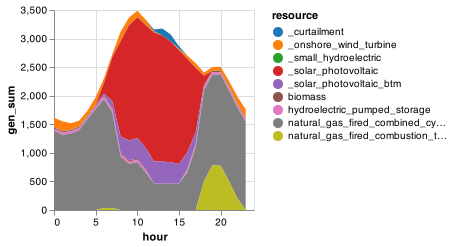

In [12]:
# Add in BTM solar and curtailment and plot results

sol_gen = innerjoin(solution.gen, 
                    gen_df[!, [:r_id, :resource]], 
                    on = :r_id)
sol_gen = combine(groupby(sol_gen, [:resource, :hour]), 
            :gen => sum)

# Rename generators (for plotting purposes)
sol_gen[sol_gen.resource .== "solar_photovoltaic", :resource] .= "_solar_photovoltaic"
sol_gen[sol_gen.resource .== "onshore_wind_turbine", :resource] .= "_onshore_wind_turbine"
sol_gen[sol_gen.resource .== "small_hydroelectric", :resource] .= "_small_hydroelectric"

# BTM solar
btm = DataFrame(resource = repeat(["_solar_photovoltaic_btm"]; outer=length(T_period)), 
    hour = T_period,
    gen_sum = gen_variable_multi[gen_variable_multi.gen_full .== "wec_sdge_solar_photovoltaic_1.0",:cf] * 600)
append!(sol_gen, btm)

# Curtailment
curtail = combine(groupby(solution.curtail, [:hour]),
            :curt => sum)
curtail[!, :resource] .= "_curtailment"
rename!(curtail, :curt_sum => :gen_sum)
append!(sol_gen, curtail[:,[:resource, :hour, :gen_sum]])

# Rescale hours
sol_gen.hour = sol_gen.hour .- T_period[1]

sol_gen |>
@vlplot(:area, 
    x=:hour, y={:gen_sum, stack=:zero}, 
    color={"resource:n", scale={scheme="category10"}})

Notice that the combined cycle plants flatten out during the day, but don't shut down due to the need for ramping capabilities in the late afternoon/evening, when solar output falls off and evening demand remains strong. This leads to some curtailment of solar from 11:00 - 16:00, which was not present in the Economic Dispatch model. All curtailment is lumped together as the model does not accurately distinguish between whether wind, solar or hydro is curtailed, which in practice is up to the system operator and depends on a variety of factors such as location, interconnection voltage, etc.

We can examine the commitment status of various units by examining the results in `solution.commit`. 

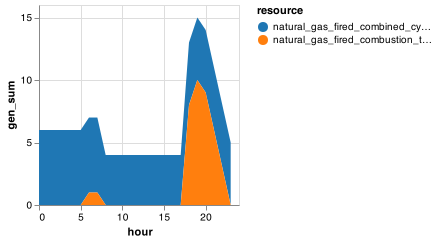

In [13]:
sol_commit = innerjoin(solution.commit, 
                    gen_df[!, [:r_id, :resource]], 
                    on = :r_id)
sol_commit = combine(groupby(sol_commit, [:resource, :hour]), 
            :gen => sum)
sol_commit.hour = sol_commit.hour .- T_period[1]

sol_commit |>
@vlplot(:area, 
    x=:hour, y={:gen_sum, stack=:zero}, 
    color={"resource:n", scale={scheme="category10"}})

Note that units shutdown during the solar period and startup for the evening peak. However, due to the commitment constraints, not all natural gas plants can be decommitted, resulting in the observed curtailment. A large number of combustion turbines turn on to meet the evening peak.

## Moderate complexity unit commitment

We expand the above unit commitment with ramp equations. These must be modified to prevent ramp violations during the startup process. In order to accommodate this, we introduce an **auxiliary variable** $GENAUX_{g,t}$ defined as the generation above the minimum output (if committed). $GENAUX_{g,t} = GEN_{g,t} = 0$ if the unit is not committed. Auxiliary variables are for convenience (we could always write the whole problem in terms of the original decision variables), but they help de-clutter the model and in general won't add too much computational penalty. The following constraints are added:

$$
\begin{align}
 & GENAUX_{g,t} = GEN_{g,t} - Pmin_{g,t}COMMIT_{g,t} & \forall \quad g \in G_{thermal} , t \in T \\
 & GENAUX_{g,t+1} - GENAUX_{g,t} \leq RampUp_{g} & \forall \quad g \in G_{thermal} , t = 1..T-1 \\
  & GENAUX_{g,t} - GENAUX_{g,t+1} \leq RampDn_{g} & \forall \quad g \in G_{thermal} , t = 1..T-1 \\
 & GEN_{g,t+1} - GEN_{g,t} \leq RampUp_{g} & \forall \quad g \notin G_{thermal} , t = 1..T-1 \\
  & GEN_{g,t} - GEN_{g,t+1} \leq RampDn_{g} & \forall \quad g \notin G_{thermal} , t = 1..T-1  
\end{align}
$$

The creation of this auxiliary variable $GENAUX$ helps us avoid violating ramping constraints when we start up our units and their generation immediately jumps up to their minium output level or during shut-down when a unit drops from minimum output (or above) to zero. 

Note you may encounter alternative formulations in the literature to address this start-up and shut-down that modify the right-hand side of the traditional ramping constraint on total generation to account for the additional step change in output during start-up or shut-down periods. The above formulation is conceptually simple and works well.

### 3. Create solver function

(We reuse steps 1 and 2 above to load packages and data.)

In [14]:
#=
Function to solve moderate complexity unit commitment problem (commitment and ramp equations)
Inputs:
    gen_df -- dataframe with generator info
    loads  -- load by time
    gen_variable -- capacity factors of variable generators (in "long" format)
    mip_gap -- desired relative MIP gap to pass to solver
=#
function unit_commitment_ramp(gen_df, loads, gen_variable, mip_gap)
    UC = Model(HiGHS.Optimizer)
    set_optimizer_attribute(UC, "mip_rel_gap", mip_gap) 

    # Define sets based on data
    # Note the creation of several different sets of generators for use in
    # different equations.
    G_thermal = gen_df[gen_df[!,:up_time] .> 0,:r_id]
    G_nonthermal = gen_df[gen_df[!,:up_time] .== 0,:r_id]
    G_var = gen_df[gen_df[!,:is_variable] .== 1,:r_id] 
    G_nonvar = gen_df[gen_df[!,:is_variable] .== 0,:r_id]
    G_nt_nonvar = intersect(G_nonvar, G_nonthermal)
    G = gen_df.r_id
    T = loads.hour
    T_red = loads.hour[1:end-1]  # reduced time periods without last one

    # Generator capacity factor time series for variable generators
    gen_var_cf = innerjoin(gen_variable, 
                    gen_df[gen_df.is_variable .== 1 , 
                        [:r_id, :gen_full, :existing_cap_mw]], 
                    on = :gen_full)
        
    # Decision variables   
    @variables(UC, begin
        GEN[G, T]  >= 0     # generation
        GENAUX[G_thermal, T] >= 0 # auxiliary generation variable
        COMMIT[G_thermal, T], Bin # commitment status (Bin=binary)
        START[G_thermal, T], Bin  # startup decision
        SHUT[G_thermal, T], Bin   # shutdown decision
    end)
                
    # Objective function
    @objective(UC, Min, 
        sum( (gen_df[gen_df.r_id .== i,:heat_rate_mmbtu_per_mwh][1] * gen_df[gen_df.r_id .== i,:fuel_cost][1] +
            gen_df[gen_df.r_id .== i,:var_om_cost_per_mwh][1]) * GEN[i,t] 
                        for i in G_nonvar for t in T) + 
        sum(gen_df[gen_df.r_id .== i,:var_om_cost_per_mwh][1] * GEN[i,t] 
                        for i in G_var for t in T) + 
        sum(gen_df[gen_df.r_id .== i,:start_cost_per_mw][1] * 
            gen_df[gen_df.r_id .== i,:existing_cap_mw][1] *
            START[i,t] 
                        for i in G_thermal for t in T)
    )
    
    # Demand constraint
    @constraint(UC, cDemand[t in T], 
        sum(GEN[i,t] for i in G) == loads[loads.hour .== t,:demand][1])

    # Capacity constraints (thermal generators requiring commitment)
    @constraint(UC, Cap_thermal_min[i in G_thermal, t in T], 
        GEN[i,t] >= COMMIT[i, t] * gen_df[gen_df.r_id .== i,:existing_cap_mw][1] *
                        gen_df[gen_df.r_id .== i,:min_power][1])
    @constraint(UC, Cap_thermal_max[i in G_thermal, t in T], 
        GEN[i,t] <= COMMIT[i, t] * gen_df[gen_df.r_id .== i,:existing_cap_mw][1])

    # Capacity constraints (non-variable generation not requiring commitment)
    @constraint(UC, Cap_nt_nonvar[i in G_nt_nonvar, t in T], 
        GEN[i,t] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1])

    # Capacity constraints (variable generation)
    @constraint(UC, Cap_var[i in 1:nrow(gen_var_cf)], 
            GEN[gen_var_cf[i,:r_id], gen_var_cf[i,:hour] ] <= 
                        gen_var_cf[i,:cf] *
                        gen_var_cf[i,:existing_cap_mw])
    
    # Unit commitment constraints
    @constraint(UC, Startup[i in G_thermal, t in T],
        COMMIT[i, t] >= sum(START[i, tt] 
                        for tt in intersect(T,
                            (t-gen_df[gen_df.r_id .== i,:up_time][1]):t)))

    @constraint(UC, Shutdown[i in G_thermal, t in T],
        1-COMMIT[i, t] >= sum(SHUT[i, tt] 
                        for tt in intersect(T,
                            (t-gen_df[gen_df.r_id .== i,:down_time][1]):t)))
    
    @constraint(UC, CommitmentStatus[i in G_thermal, t in T_red],
        COMMIT[i,t+1] - COMMIT[i,t] == START[i,t+1] - SHUT[i,t+1])
    
    # New auxiliary variable GENAUX for generation above the minimum output level
    # for committed thermal units (only created for thermal generators)
    @constraint(UC, AuxGen[i in G_thermal, t in T],
        GENAUX[i,t] == GEN[i,t] - COMMIT[i, t] * gen_df[gen_df.r_id .== i,:existing_cap_mw][1] *
                        gen_df[gen_df.r_id .== i,:min_power][1])
    
    # Ramp equations for thermal generators (constraining GENAUX)
    @constraint(UC, RampUp_thermal[i in G_thermal, t in T_red], 
        GENAUX[i,t+1] - GENAUX[i,t] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1] * 
                                 gen_df[gen_df.r_id .== i,:ramp_up_percentage][1] )

    @constraint(UC, RampDn_thermal[i in G_thermal, t in T_red], 
        GENAUX[i,t] - GENAUX[i,t+1] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1] * 
                                 gen_df[gen_df.r_id .== i,:ramp_dn_percentage][1] )

    # Ramp equations for non-thermal generators (constraining total generation GEN)
    @constraint(UC, RampUp_nonthermal[i in G_nonthermal, t in T_red], 
        GEN[i,t+1] - GEN[i,t] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1] * 
                                 gen_df[gen_df.r_id .== i,:ramp_up_percentage][1] )

    @constraint(UC, RampDn[i in G, t in T_red], 
        GEN[i,t] - GEN[i,t+1] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1] * 
                                 gen_df[gen_df.r_id .== i,:ramp_dn_percentage][1] )
      
    
    # Solve statement (! indicates runs in place)
    optimize!(UC)

    # Generation solution
    gen = value_to_df_2dim(value.(GEN))

    # Commitment status solution
    commit = value_to_df_2dim(value.(COMMIT))

    # Calculate curtailment
    curtail = innerjoin(gen_var_cf, gen, on = [:r_id, :hour])
    curtail.curt = curtail.cf .* curtail.existing_cap_mw - curtail.gen
    
    # Return the solution and objective as named tuple
    return (
        gen,
        commit,
        curtail,
        cost = objective_value(UC),
        status = termination_status(UC)
    )

end

unit_commitment_ramp (generic function with 1 method)

### 4. Solve a day's unit commitment

Presolving model
4230 rows, 2705 cols, 12697 nonzeros
2978 rows, 1981 cols, 11613 nonzeros
2058 rows, 1889 cols, 10517 nonzeros
1942 rows, 1792 cols, 9838 nonzeros

Solving MIP model with:
   1942 rows
   1792 cols (1216 binary, 0 integer, 0 implied int., 576 continuous)
   9838 nonzeros

( 0.0s) Starting symmetry detection
( 0.0s) No symmetry present

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   -18497.611619   inf                  inf        0      0      0         0     0.0s
         0       0         0   0.00%   853909.258012   inf                  inf        0      0      6       484     0.0s
 C       0       0         0   0.00%   854324.132101   926742.140347      7.81%      739     31    107       612     0.1s
 L       0       0         0   0.0

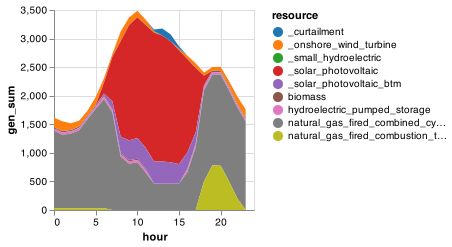

In [15]:
solution = unit_commitment_ramp(
    gen_df_sens, loads_multi, gen_variable_multi, 0.01); # 1% MIP gap

# Add in BTM solar and curtailment and plot results

sol_gen = innerjoin(solution.gen, 
                    gen_df[!, [:r_id, :resource]], 
                    on = :r_id)
sol_gen = combine(groupby(sol_gen, [:resource, :hour]), 
            :gen => sum)

# Rename generators (for plotting purposes)
sol_gen[sol_gen.resource .== "solar_photovoltaic", :resource] .= "_solar_photovoltaic"
sol_gen[sol_gen.resource .== "onshore_wind_turbine", :resource] .= "_onshore_wind_turbine"
sol_gen[sol_gen.resource .== "small_hydroelectric", :resource] .= "_small_hydroelectric"

# BTM solar
btm = DataFrame(resource = repeat(["_solar_photovoltaic_btm"]; outer=length(T_period)), 
    hour = T_period,
    gen_sum = gen_variable_multi[gen_variable_multi.gen_full .== "wec_sdge_solar_photovoltaic_1.0",:cf] * 600)
append!(sol_gen, btm)

# Curtailment
curtail = combine(groupby(solution.curtail, [:hour]),
            :curt => sum)
curtail[!, :resource] .= "_curtailment"
rename!(curtail, :curt_sum => :gen_sum)
append!(sol_gen, curtail[:,[:resource, :hour, :gen_sum]])

# Rescale hours
sol_gen.hour = sol_gen.hour .- T_period[1]

sol_gen |>
@vlplot(:area, 
    x=:hour, y={:gen_sum, stack=:zero}, 
    color={"resource:n", scale={scheme="category10"}})

In contrast to when we added ramp constraints to the Economic Dispatch problem, adding ramp constraints to our Unit Commitment formulation does not change the solution as much (at least in this case). Much of the inflexibility here arises from the unit commitment constraints, and once committed, there is ample ramping capability. We do however get relatively more combustion turbines running to meet the evening ramp, given their faster ramp rates.

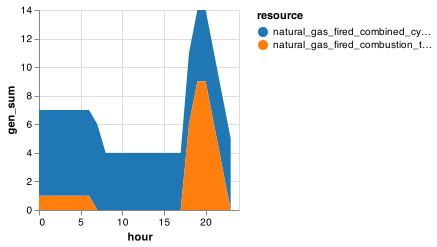

In [16]:
sol_commit = innerjoin(solution.commit, 
                    gen_df[!, [:r_id, :resource]], 
                    on = :r_id)
sol_commit = combine(groupby(sol_commit, [:resource, :hour]), 
            :gen => sum)
sol_commit.hour = sol_commit.hour .- T_period[1]

sol_commit |>
@vlplot(:area, 
    x=:hour, y={:gen_sum, stack=:zero}, 
    color={"resource:n", scale={scheme="category10"}})

A case involving more large coal or nuclear units with slower ramping limits than gas turbines or combined cycle plants might find ramp constraints more limiting. As in many cases, the impact of constraints is case dependent, and modelers must exercise some judicious application of domain knowledge (and experimentation with alternative formulations) to decide how complex your model should be to reflect important *binding* constraints that actually shape your outcomes of interest. Where constraints are non-binding or second order, it may be more practical to omit them entirely, reducing the computational intensity (solve time) of your model...

## Unit commitment with ramping and reserves

We now add spinning reserve requirements to the model. Spinning reserves refer to generation capacity that is online and able to generate (e.g., within 10-30 minutes) if needed by the system operator. (Note: in Europe, these are referred to as 'replacement reserves' or formerly 'tertiary reserves.') The SO will establish reserve requirements to maintain sufficient capacity to respond to demand or supply forecast errors or in case of "contingencies," such as the unplanned and sudden loss of a generating station or a transmission line. The SO then typically operates a reserve market to competitively procure this available capacity. Most SO's actually define several classes of reserve products defined by their response time and period over which they may be activated. 

Here we will focus on spinning reserve requirements and establish a simple set of reserve requirements for reserves up (ability to quickly increase output) and reserves down (ability to quickly reduce output):

$$
\begin{align}
 & ResReqUp_t = 300 MW + 5\% \times Demand_t  &\forall \quad t \in T \\
 & ResReqDn_t = 5\% \times Demand_t & \forall \quad t \in T
\end{align}
$$

Here, $300 MW$ is our contigency reserves, meant to ensure we have sufficient upwards ramping capability online and available to cover the unexpected loss of 300 MW worth of generation. 

The 5% of demand term in the constraints above is meant to provide sufficient reserves in either upwards or downwards direction to cover errors in the demand forecast. For simplicity, we ignore solar PV and wind production in our reserve calculation, though in practice, we would want to consider solar and wind forecast errors in calculating up reserve requirements as well.

In our simple system, only thermal generators provide reserves. (This can be easily adjusted by changing the sets and defining the potential reserve contributions for different sets of resources differently, such as storage or hydro resources). The contribution of each generators to meeting reserves and the overall reserve constraint are thus given by:

$$
\begin{align}
 & RESUP_{g,t} \leq Pmax_{g,t}COMMIT_{g,t} - GEN_{g,t} & \forall \quad g \in G_{thermal} , t \in T \\
 & RESDN_{g,t} \leq GEN_{g,t} - Pmin_{g,t}COMMIT_{g,t} & \forall \quad g \in G_{thermal} , t \in T \\
 & RESUP_{g,t} \leq RampUp_{g} & \forall \quad g \in G_{thermal}, t \in T\\ 
 & RESDN_{g,t} \leq RampDn_{g} & \forall \quad g \in G_{thermal}, t \in T \\
 & \sum_{g \in G_{thermal}} RESUP_{g,t} \geq ResReqUp_t & \forall \quad t \in T \\
 & \sum_{g \in G_{thermal}} RESDN_{g,t} \geq ResReqDn_t & \forall \quad t \in T
\end{align}
$$

We have added two new **decision variables**:

- $RESUP_{g,t}$, up-reserve capacity (in MW) of generator $g$ at time $t$
- $RESDN_{g,t}$, down-reserve capacity (in MW) of generator $g$ at time $t$

Note that in this case, we constrain the reserve contribution for each thermal generator to be the same as their hourly ramp rates, $RampUp_{g}, RampDown_{g}$. In practice, reserve products typically require a faster response time, on the order of 10-30 minutes for "tertiary" reserves (aka spinning reserves or contingency reserves), and 5-15 minutes for "secondary" reserves (regulation reserves). Thus, depending on the reserve requirements being modeled, one might specify a distinct maximum reserve contribution for each unit that reflects their ramping capabilities over shorter time periods.

<img src="img/reserves.png" style="width: 450px; height: auto" align="left">

<img src="img/reserves_taxonomy.png" style="width: 450px; height: auto" align="left">

### 3. Create solver function

(We reuse steps 1 and 2 above to load packages and data.)

In [17]:
#=
Function to solve full unit commitment problem (commitment, ramp, reserve equations)
Inputs:
    gen_df -- dataframe with generator info
    loads  -- load by time
    gen_variable -- capacity factors of variable generators (in "long" format)
    mip_gap -- desired relative MIP gap to pass to solver
=#
function unit_commitment_full(gen_df, loads, gen_variable, mip_gap)
    UC = Model(HiGHS.Optimizer)
    set_optimizer_attribute(UC, "mip_rel_gap", mip_gap)

    # Define sets based on data
    # Note the creation of several different sets of generators for use in
    # different equations.
    G_thermal = gen_df[gen_df[!,:up_time] .> 0,:r_id]
    G_nonthermal = gen_df[gen_df[!,:up_time] .== 0,:r_id]
    G_var = gen_df[gen_df[!,:is_variable] .== 1,:r_id] 
    G_nonvar = gen_df[gen_df[!,:is_variable] .== 0,:r_id]
    G_nt_nonvar = intersect(G_nonvar, G_nonthermal)
    G = gen_df.r_id
    T = loads.hour
    T_red = loads.hour[1:end-1]  # reduced time periods without last one

    # Generator capacity factor time series for variable generators
    gen_var_cf = innerjoin(gen_variable, 
                    gen_df[gen_df.is_variable .== 1 , 
                        [:r_id, :gen_full, :existing_cap_mw, :resource]], 
                    on = :gen_full)
    gen_var_cf.max_gen = gen_var_cf.cf .* gen_var_cf.existing_cap_mw
    
    # Compute reserve requirements
    ResReqUp = Dict(T[i] => 300  
              + 0.05 * loads[loads.hour .== T[i],:demand][1]
                    for i in 1:length(T))
    ResReqDn = Dict(T[i] => 0
              + 0.05 * loads[loads.hour .== T[i],:demand][1]                    
                    for i in 1:length(T))
    
    # Decision variables   
    @variables(UC, begin
        GEN[G, T]  >= 0     # generation
        GENAUX[G_thermal, T] >= 0 # auxiliary generation variable
        COMMIT[G_thermal, T], Bin # commitment status (Bin=binary)
        START[G_thermal, T], Bin  # startup decision
        SHUT[G_thermal, T], Bin   # shutdown decision
        RESUP[G_thermal, T]       # up reserve capacity
        RESDN[G_thermal, T]       # down reserve capacity
    end)
                
    # Objective function
    @objective(UC, Min, 
        sum( (gen_df[gen_df.r_id .== i,:heat_rate_mmbtu_per_mwh][1] * gen_df[gen_df.r_id .== i,:fuel_cost][1] +
            gen_df[gen_df.r_id .== i,:var_om_cost_per_mwh][1]) * GEN[i,t] 
                        for i in G_nonvar for t in T) + 
        sum(gen_df[gen_df.r_id .== i,:var_om_cost_per_mwh][1] * GEN[i,t] 
                        for i in G_var for t in T) + 
        sum(gen_df[gen_df.r_id .== i,:start_cost_per_mw][1] * 
            gen_df[gen_df.r_id .== i,:existing_cap_mw][1] *
            START[i,t] 
                        for i in G_thermal for t in T)
    )
    
    # Demand constraint
    @constraint(UC, cDemand[t in T], 
        sum(GEN[i,t] for i in G) == loads[loads.hour .== t,:demand][1])

    # Capacity constraints (thermal generators requiring commitment)
    @constraint(UC, Cap_thermal_min[i in G_thermal, t in T], 
        GEN[i,t] >= COMMIT[i, t] * gen_df[gen_df.r_id .== i,:existing_cap_mw][1] *
                        gen_df[gen_df.r_id .== i,:min_power][1])
    @constraint(UC, Cap_thermal_max[i in G_thermal, t in T], 
        GEN[i,t] <= COMMIT[i, t] * gen_df[gen_df.r_id .== i,:existing_cap_mw][1])

    # Capacity constraints (non-variable generation not requiring commitment)
    @constraint(UC, Cap_nt_nonvar[i in G_nt_nonvar, t in T], 
        GEN[i,t] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1])

    # Capacity constraints (variable generation)
    @constraint(UC, Cap_var[i in 1:nrow(gen_var_cf)], 
            GEN[gen_var_cf[i,:r_id], gen_var_cf[i,:hour] ] <= 
                        gen_var_cf[i,:max_gen])
    
    # Unit commitment constraints
    @constraint(UC, Startup[i in G_thermal, t in T],
        COMMIT[i, t] >= sum(START[i, tt] 
                        for tt in intersect(T,
                            (t-gen_df[gen_df.r_id .== i,:up_time][1]):t)))

    @constraint(UC, Shutdown[i in G_thermal, t in T],
        1-COMMIT[i, t] >= sum(SHUT[i, tt] 
                        for tt in intersect(T,
                            (t-gen_df[gen_df.r_id .== i,:down_time][1]):t)))
    
    @constraint(UC, CommitmentStatus[i in G_thermal, t in T_red],
        COMMIT[i,t+1] - COMMIT[i,t] == START[i,t+1] - SHUT[i,t+1])
    
    # Auxiliary variable
    @constraint(UC, AuxGen[i in G_thermal, t in T],
        GENAUX[i,t] == GEN[i,t] - COMMIT[i, t] * gen_df[gen_df.r_id .== i,:existing_cap_mw][1] *
                        gen_df[gen_df.r_id .== i,:min_power][1])
    
    # Ramp equations (thermal generators)
    @constraint(UC, RampUp_thermal[i in G_thermal, t in T_red], 
        GENAUX[i,t+1] - GENAUX[i,t] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1] * 
                                 gen_df[gen_df.r_id .== i,:ramp_up_percentage][1] )

    @constraint(UC, RampDn_thermal[i in G_thermal, t in T_red], 
        GENAUX[i,t] - GENAUX[i,t+1] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1] * 
                                 gen_df[gen_df.r_id .== i,:ramp_dn_percentage][1] )

    # Ramp equations (non-thermal generators)
    @constraint(UC, RampUp_nonthermal[i in G_nonthermal, t in T_red], 
        GEN[i,t+1] - GEN[i,t] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1] * 
                                 gen_df[gen_df.r_id .== i,:ramp_up_percentage][1] )

    @constraint(UC, RampDn[i in G, t in T_red], 
        GEN[i,t] - GEN[i,t+1] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1] * 
                                 gen_df[gen_df.r_id .== i,:ramp_dn_percentage][1] )
      
    # Reserve equations
    # (1) Reserves limited by committed capacity of generator
    @constraint(UC, ResUpCap[i in G_thermal, t in T],
        RESUP[i,t] <= COMMIT[i, t] * gen_df[gen_df.r_id .== i,:existing_cap_mw][1]
                        - GEN[i,t])

    @constraint(UC, ResDnCap[i in G_thermal, t in T],
        RESDN[i,t] <= GEN[i,t] - 
                        COMMIT[i, t] * gen_df[gen_df.r_id .== i,:existing_cap_mw][1] *
                        gen_df[gen_df.r_id .== i,:min_power][1])

    # (2) Reserves limited by ramp rates
    @constraint(UC, ResUpRamp[i in G_thermal, t in T],
        RESUP[i,t] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1] * 
                          gen_df[gen_df.r_id .== i,:ramp_up_percentage][1])

    @constraint(UC, ResDnRamp[i in G_thermal, t in T],
        RESDN[i,t] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1] * 
                          gen_df[gen_df.r_id .== i,:ramp_dn_percentage][1])

    # (3) Overall reserve requirements
    @constraint(UC, ResUpRequirement[t in T],
        sum(RESUP[i,t] for i in G_thermal) >= 
                ResReqUp[t])

    @constraint(UC, ResDnRequirement[t in T],
        sum(RESDN[i,t] for i in G_thermal) >= 
                ResReqDn[t])

    # Solve statement (! indicates runs in place)
    optimize!(UC)

    # Generation solution
    gen = value_to_df_2dim(value.(GEN))

    # Commitment status solution
    commit = value_to_df_2dim(value.(COMMIT))

    # Calculate curtailment
    curtail = innerjoin(gen_var_cf, gen, on = [:r_id, :hour])
    curtail.curt = curtail.cf .* curtail.existing_cap_mw - curtail.gen
    
    # Return the solution and objective as named tuple
    return (
        gen,
        commit,
        curtail,
        cost = objective_value(UC),
        status = termination_status(UC)
    )

end

unit_commitment_full (generic function with 1 method)

### 4. Solve the model and plot results

**Note: this might take a little while depending on your machine.**

Presolving model
5334 rows, 3761 cols, 16921 nonzeros
3795 rows, 2750 cols, 13799 nonzeros
2805 rows, 2588 cols, 13303 nonzeros
2194 rows, 2004 cols, 12003 nonzeros
2179 rows, 2000 cols, 11839 nonzeros

Solving MIP model with:
   2179 rows
   2000 cols (1232 binary, 0 integer, 0 implied int., 768 continuous)
   11839 nonzeros

( 0.0s) Starting symmetry detection
( 0.0s) No symmetry present

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   -16834.579667   inf                  inf        0      0      0         0     0.0s
         0       0         0   0.00%   897185.423847   inf                  inf        0      0      0       643     0.1s
 R       0       0         0   0.00%   898446.461994   931073.28755       3.50%      546     25      0       688     

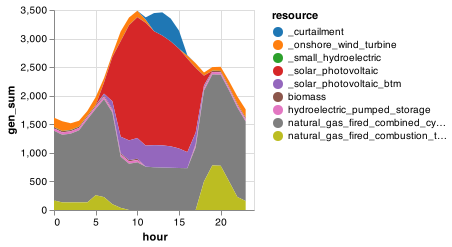

In [18]:
solution = unit_commitment_full(gen_df_sens, loads_multi, gen_variable_multi, 0.02);
 # To keep solve times to a few minutes, we increase the MIP gap tolerance
 # in this more complex case to 2% (mip_gap=0.02). You can play with this setting to see 
 # how the MIP gap affects solve times on your computer.
   

# Add in BTM solar and curtailment and plot results

sol_gen = innerjoin(solution.gen, 
                    gen_df[!, [:r_id, :resource]], 
                    on = :r_id)
sol_gen = combine(groupby(sol_gen, [:resource, :hour]), 
            :gen => sum)

# Rename generators (for plotting purposes)
sol_gen[sol_gen.resource .== "solar_photovoltaic", :resource] .= "_solar_photovoltaic"
sol_gen[sol_gen.resource .== "onshore_wind_turbine", :resource] .= "_onshore_wind_turbine"
sol_gen[sol_gen.resource .== "small_hydroelectric", :resource] .= "_small_hydroelectric"

# BTM solar
btm = DataFrame(resource = repeat(["_solar_photovoltaic_btm"]; outer=length(T_period)), 
    hour = T_period,
    gen_sum = gen_variable_multi[gen_variable_multi.gen_full .== "wec_sdge_solar_photovoltaic_1.0",:cf] * 600)
append!(sol_gen, btm)

# Curtailment
curtail = combine(groupby(solution.curtail, [:hour]),
            :curt => sum)
curtail[!, :resource] .= "_curtailment"
rename!(curtail, :curt_sum => :gen_sum)
append!(sol_gen, curtail[:,[:resource, :hour, :gen_sum]])

# Rescale hours
sol_gen.hour = sol_gen.hour .- T_period[1]

sol_gen |>
@vlplot(:area, 
    x=:hour, y={:gen_sum, stack=:zero}, 
    color={"resource:n", scale={scheme="category10"}})

We can now see that the need to maintain reserve requirements leads to greater commitment of natural gas units throughout the day. The addition of CCGTs and GTs to meet reserve requirements leads to greater curtailment of wind and solar in the afternoon hours. We also see more CT units committed during the morning ramp as well as the afternoon hours to help provide reserves.

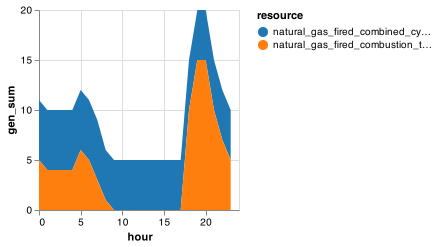

In [19]:
sol_commit = innerjoin(solution.commit, 
                    gen_df[!, [:r_id, :resource]], 
                    on = :r_id)
sol_commit = combine(groupby(sol_commit, [:resource, :hour]), 
            :gen => sum)
sol_commit.hour = sol_commit.hour .- T_period[1]

sol_commit |>
@vlplot(:area, 
    x=:hour, y={:gen_sum, stack=:zero}, 
    color={"resource:n", scale={scheme="category10"}})

### Further resources

Knueven, B., Ostrowski, J., & Watson, J.-P. (2019). On Mixed Integer Programming Formulations for the Unit Commitment Problem. Optimization Online, 91. http://www.optimization-online.org/DB_FILE/2018/11/6930.pdf

Morales-Espana, G., Latorre, J. M., & Ramos, A. (2013). Tight and Compact MILP Formulation of Start-Up and Shut-Down Ramping in Unit Commitment. IEEE Transactions on Power Systems, 28(2), 1288–1296. https://doi.org/10.1109/TPWRS.2012.2222938

Morales-España, G., Ramírez-Elizondo, L., & Hobbs, B. F. (2017). Hidden power system inflexibilities imposed by traditional unit commitment formulations. Applied Energy, 191, 223–238. https://doi.org/10.1016/j.apenergy.2017.01.089

Ostrowski, J., Anjos, M. F., & Vannelli, A. (2012). Tight Mixed Integer Linear Programming Formulations for the Unit Commitment Problem. IEEE Transactions on Power Systems, 27(1), 39–46. https://doi.org/10.1109/TPWRS.2011.2162008